In [1]:
#Install xgboost and line, I already have instatted this package
#!pip install xgboost
#!pip install lime

# Example-1

In [2]:
import pandas as pd
import xgboost as xgb
import shap
import lime
import lime.lime_tabular
#
# read the dataset
df = pd.read_csv('student-mat.csv', delimiter=',')
# drop columns that are less related to the target based on my judgement
cols_to_drop = ['school', 'address', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'famsup', 
                'romantic', 'goout', 'Dalc', 'Walc', 'health', 'G1', 'G2']
# at the same time, rename the columns so that they are understandable
df = df.drop(columns=cols_to_drop).rename(columns={'famsize': 'family_size', 'Pstatus': 'parent_cohab_status', 
                                                   'traveltime': 'travel_time_school', 'studytime': 'study_time', 
                                                   'failures': 'past_failures', 'schoolsup': 'extra_support', 
                                                   'paid': 'extra_paid_classes', 'activities': 'extra_curricular', 
                                                   'nursery': 'nursery_school', 'higher': 'want_higher_edu', 
                                                   'internet': 'internet_access', 'famrel': 'family_relationships', 
                                                   'freetime': 'free_time', 'absences': 'number_absences', 
                                                   'G3': 'score'})
df.head()

C:\Users\Taslima Akter\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


sex  age family_size parent_cohab_status  travel_time_school  study_time  \
0   F   18         GT3                   A                   2           2   
1   F   17         GT3                   T                   1           2   
2   F   15         LE3                   T                   1           2   
3   F   15         GT3                   T                   1           3   
4   F   16         GT3                   T                   1           2   

   past_failures extra_support extra_paid_classes extra_curricular  \
0              0           yes                 no               no   
1              0            no                 no               no   
2              3           yes                yes               no   
3              0            no                yes              yes   
4              0            no                yes               no   

  nursery_school want_higher_edu internet_access  family_relationships  \
0            yes             yes              no                     4   
1             no             yes             yes                     5   
2            yes             yes             yes                     4   
3            yes             yes             yes                     3   
4            yes             yes              no                     4   

   free_time  number_absences  score  
0          3                6      6  
1          3                4      6  
2          3               10     10  
3          2                2     15  
4          3                4     10

In [3]:
# convert categorical variables into dummy variables
df = pd.get_dummies(df, drop_first=True)
# define the features
df_features = df.drop(columns='score')
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   age                     395 non-null    int64
 1   travel_time_school      395 non-null    int64
 2   study_time              395 non-null    int64
 3   past_failures           395 non-null    int64
 4   family_relationships    395 non-null    int64
 5   free_time               395 non-null    int64
 6   number_absences         395 non-null    int64
 7   sex_M                   395 non-null    uint8
 8   family_size_LE3         395 non-null    uint8
 9   parent_cohab_status_T   395 non-null    uint8
 10  extra_support_yes       395 non-null    uint8
 11  extra_paid_classes_yes  395 non-null    uint8
 12  extra_curricular_yes    395 non-null    uint8
 13  nursery_school_yes      395 non-null    uint8
 14  want_higher_edu_yes     395 non-null    uint8
 15  internet_access_yes    

In [4]:
#build XGBoost model using all data available
# set some parameters to make the model more complicated
model = xgb.XGBRegressor(n_estimators=500, max_depth=20, learning_rate=0.1, subsample=0.8, random_state=33)
model.fit(df_features, df['score'])

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=20, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=33,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


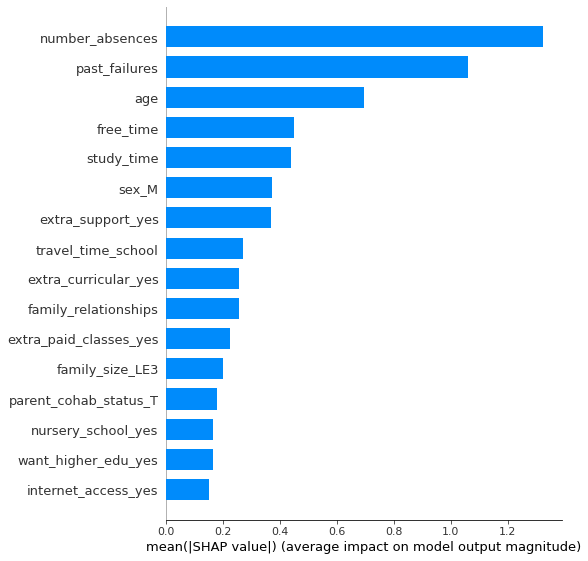

In [5]:
# feature importance
#The target variable is score; the number of absence, past_failure, age are affecting much compared to score.
#If the number of absence is more the number of score is goint to reduce
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(df_features)
shap.summary_plot(shap_values, df_features, plot_type="bar")

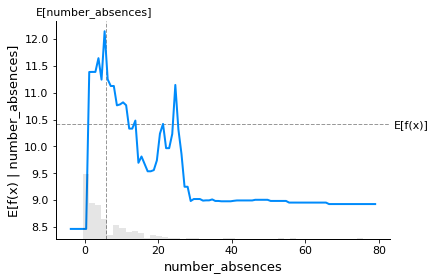

In [6]:
#vertical line-avg value of absence
#Horizental line is avg value of score
#E[f(x)]=expected value of score
shap.plots.partial_dependence(
    'number_absences', model.predict, df_features, 
    ice=False, model_expected_value=True, feature_expected_value=True
)

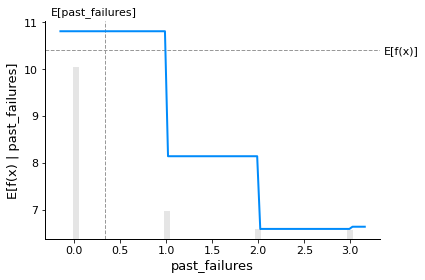

In [7]:
shap.plots.partial_dependence(
    'past_failures', model.predict, df_features, 
    ice=False, model_expected_value=True, feature_expected_value=True
)

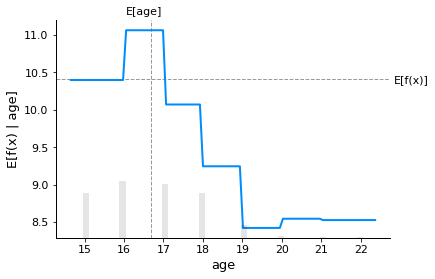

In [8]:
shap.plots.partial_dependence(
    'age', model.predict, df_features, 
    ice=False, model_expected_value=True, feature_expected_value=True
)

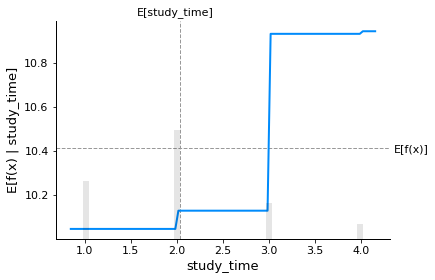

In [9]:
shap.plots.partial_dependence(
    'study_time', model.predict, df_features, 
    ice=False, model_expected_value=True, feature_expected_value=True
)

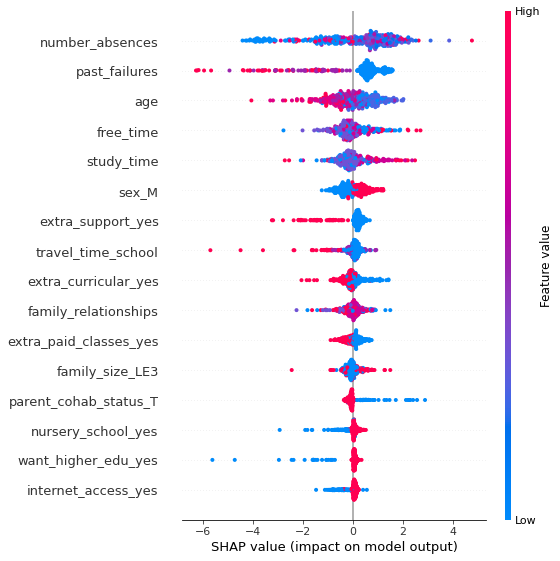

In [10]:
#Created TreeExplainer
explainer = shap.TreeExplainer(model)
shap_values = explainer(df_features)
shap.summary_plot(shap_values, df_features)

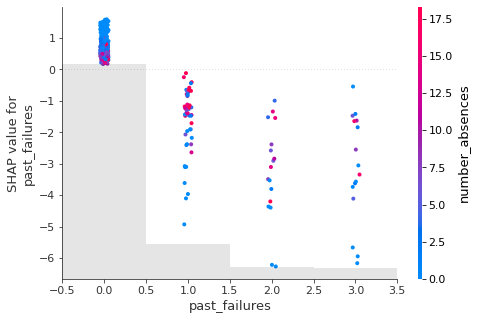

In [11]:
#Creating Scatter Plot
shap.plots.scatter(shap_values[:,'past_failures'], color=shap_values)

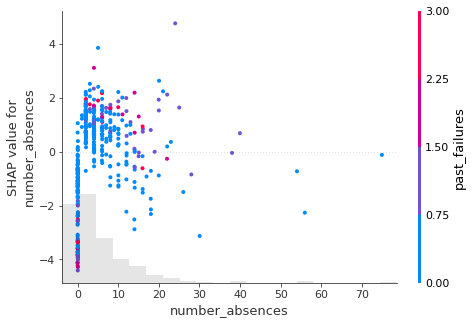

In [12]:
shap.plots.scatter(shap_values[:,'number_absences'], color=shap_values)

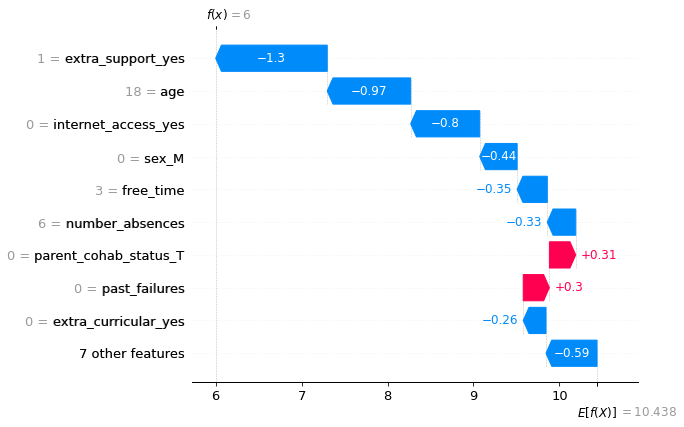

In [13]:
#Creating Waterfall Plot
shap.plots.waterfall(shap_values[0])

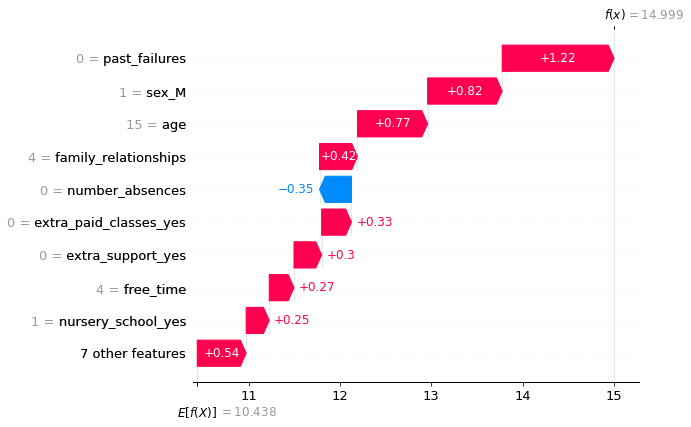

In [14]:
#Creating Waterfall Plot in other way
shap.plots.waterfall(shap_values[20])

In [15]:
#LimeTabularExplainer class and reshapes the training data and feature names
explainer = lime.lime_tabular.LimeTabularExplainer(
    df_features.to_numpy(), feature_names=df_features.columns, class_names=['score'], 
    verbose=True, mode='regression', random_state=33)

In [16]:
exp = explainer.explain_instance(df_features.iloc[20], model.predict, num_features=5)

Intercept 5.8006425125931775
Prediction_local [9.94061039]
Right: 14.999445


In [17]:
exp.show_in_notebook(show_table=True)

In [18]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   age                     395 non-null    int64
 1   travel_time_school      395 non-null    int64
 2   study_time              395 non-null    int64
 3   past_failures           395 non-null    int64
 4   family_relationships    395 non-null    int64
 5   free_time               395 non-null    int64
 6   number_absences         395 non-null    int64
 7   sex_M                   395 non-null    uint8
 8   family_size_LE3         395 non-null    uint8
 9   parent_cohab_status_T   395 non-null    uint8
 10  extra_support_yes       395 non-null    uint8
 11  extra_paid_classes_yes  395 non-null    uint8
 12  extra_curricular_yes    395 non-null    uint8
 13  nursery_school_yes      395 non-null    uint8
 14  want_higher_edu_yes     395 non-null    uint8
 15  internet_access_yes    

In [19]:
# retrain with monotonicity constrain
params = {
    'monotone_constraints':'(0,0,1,-1,0,0,-1)'
}
model_constrained = xgb.XGBRegressor(**params, n_estimators=500, max_depth=20, learning_rate=0.1, subsample=0.8, random_state=33)
model_constrained.fit(df_features, df['score'])

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=20, min_child_weight=1, missing=nan,
             monotone_constraints='(0,0,1,-1,0,0,-1)', n_estimators=500,
             n_jobs=8, num_parallel_tree=1, predictor='auto', random_state=33,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

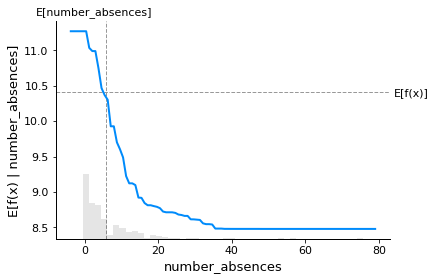

In [20]:
import shap
shap.plots.partial_dependence(
    'number_absences', model_constrained.predict, df_features, 
    ice=False, model_expected_value=True, feature_expected_value=True
)

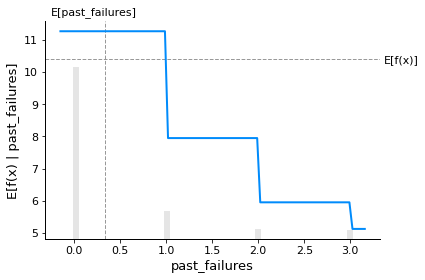

In [21]:
shap.plots.partial_dependence(
    'past_failures', model_constrained.predict, df_features, 
    ice=False, model_expected_value=True, feature_expected_value=True
)

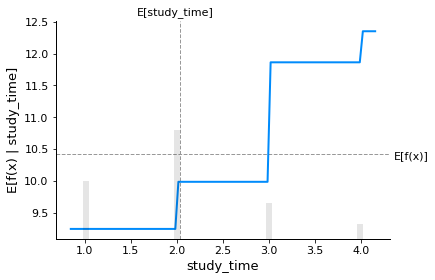

In [22]:
shap.plots.partial_dependence(
    'study_time', model_constrained.predict, df_features, 
    ice=False, model_expected_value=True, feature_expected_value=True
)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


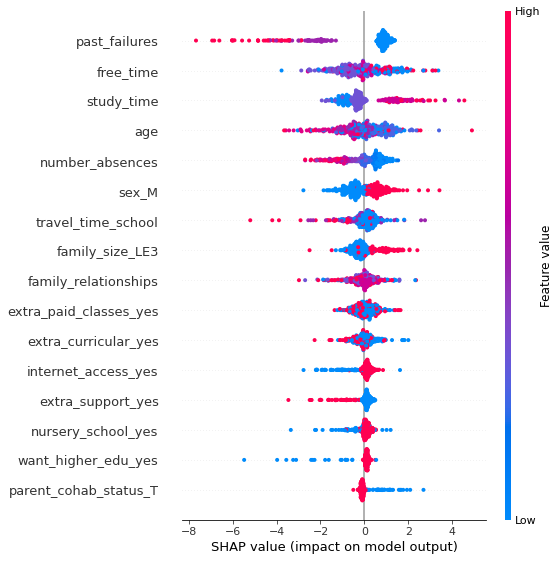

In [23]:
#Re-created TreeExplainer
explainer = shap.TreeExplainer(model_constrained)
shap_values = explainer(df_features)
shap.summary_plot(shap_values, df_features)

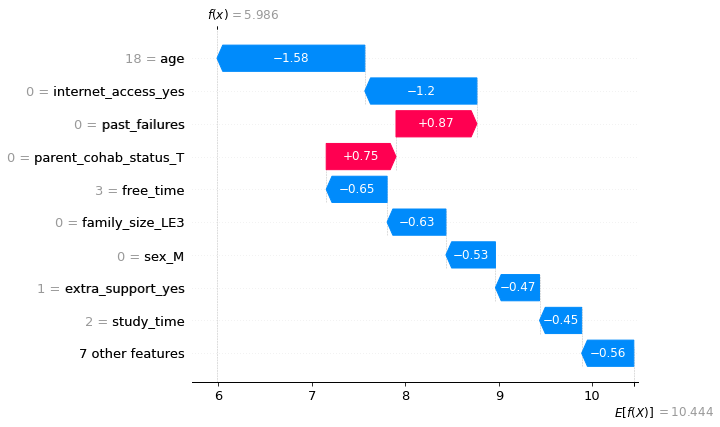

In [24]:
shap.plots.waterfall(shap_values[0])

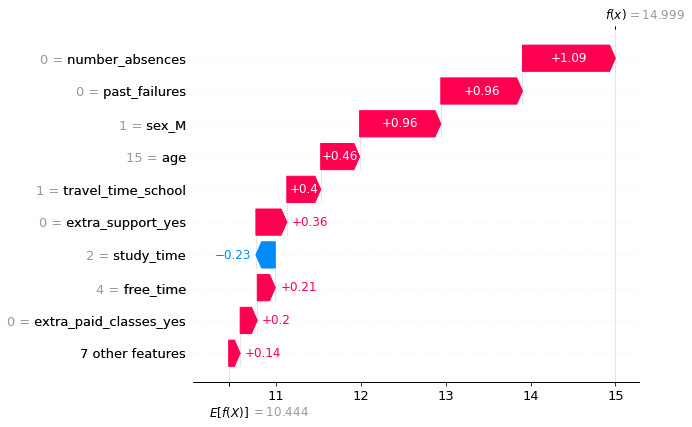

In [25]:
shap.plots.waterfall(shap_values[20])

In [26]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    df_features.to_numpy(), feature_names=df_features.columns, class_names=['score'], 
    verbose=True, mode='regression', random_state=33)

In [27]:
exp = explainer.explain_instance(df_features.iloc[20], model_constrained.predict, num_features=5)

Intercept 4.160316689146363
Prediction_local [12.93215198]
Right: 14.998528


In [28]:
exp.show_in_notebook(show_table=True)

# Example-2, Lab-3 Assignment

# Data Loading, Preparation and Feature Engineering Part:

In [29]:
#Load the dataset
df_c = pd.read_csv('compas-scores-two-years.csv')

In [30]:
#Display data of the dataset
df_c.head()

id                name   first         last compas_screening_date   sex  \
0   1    miguel hernandez  miguel    hernandez            2013-08-14  Male   
1   3         kevon dixon   kevon        dixon            2013-01-27  Male   
2   4            ed philo      ed        philo            2013-04-14  Male   
3   5         marcu brown   marcu        brown            2013-01-13  Male   
4   6  bouthy pierrelouis  bouthy  pierrelouis            2013-03-26  Male   

          dob  age          age_cat              race  ...  v_decile_score  \
0  1947-04-18   69  Greater than 45             Other  ...               1   
1  1982-01-22   34          25 - 45  African-American  ...               1   
2  1991-05-14   24     Less than 25  African-American  ...               3   
3  1993-01-21   23     Less than 25  African-American  ...               6   
4  1973-01-22   43          25 - 45             Other  ...               1   

   v_score_text  v_screening_date  in_custody  out_custody  priors_count.1  \
0           Low        2013-08-14  2014-07-07   2014-07-14               0   
1           Low        2013-01-27  2013-01-26   2013-02-05               0   
2           Low        2013-04-14  2013-06-16   2013-06-16               4   
3        Medium        2013-01-13         NaN          NaN               1   
4           Low        2013-03-26         NaN          NaN               2   

  start   end event two_year_recid  
0     0   327     0              0  
1     9   159     1              1  
2     0    63     0              1  
3     0  1174     0              0  
4     0  1102     0              0  

[5 rows x 53 columns]

In [31]:
#Display info of the dataset
df_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 53 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       7214 non-null   int64  
 1   name                     7214 non-null   object 
 2   first                    7214 non-null   object 
 3   last                     7214 non-null   object 
 4   compas_screening_date    7214 non-null   object 
 5   sex                      7214 non-null   object 
 6   dob                      7214 non-null   object 
 7   age                      7214 non-null   int64  
 8   age_cat                  7214 non-null   object 
 9   race                     7214 non-null   object 
 10  juv_fel_count            7214 non-null   int64  
 11  decile_score             7214 non-null   int64  
 12  juv_misd_count           7214 non-null   int64  
 13  juv_other_count          7214 non-null   int64  
 14  priors_count            

# Note about Target variable:

two_year_recid->in the next two years the person is going to do wrong and come into jail


# Data Preparation:
 
-I have deleted many of the features of the dataset, which I think have less impact on the target variable.
-I also have changed a column name to make it more understandable.

In [32]:
# Droping the columns, which I found have no such mentionable impact to the target variable

cols_to_drop = ['id','name','first','last','compas_screening_date','dob','juv_fel_count', 'juv_misd_count','juv_other_count','days_b_screening_arrest',
                'c_jail_in', 'c_jail_out','c_case_number','c_offense_date','c_days_from_compas','c_charge_desc','c_arrest_date',
                'c_charge_degree','r_case_number','r_charge_degree','r_days_from_arrest','r_offense_date','r_jail_in', 'r_jail_out',
                'violent_recid','vr_case_number','vr_charge_degree','vr_offense_date','vr_charge_desc','type_of_assessment','v_score_text',
                'screening_date','v_type_of_assessment','v_screening_date','in_custody','out_custody','start','end','event', 'decile_score.1','is_recid',
                'r_charge_desc', 'is_violent_recid','priors_count.1']
# at the same time, rename the columns so that they are understandable
df_c = df_c.drop(columns=cols_to_drop).rename(columns={'score_text': 'crime_level'})
df_c

sex  age          age_cat              race  decile_score  \
0       Male   69  Greater than 45             Other             1   
1       Male   34          25 - 45  African-American             3   
2       Male   24     Less than 25  African-American             4   
3       Male   23     Less than 25  African-American             8   
4       Male   43          25 - 45             Other             1   
...      ...  ...              ...               ...           ...   
7209    Male   23     Less than 25  African-American             7   
7210    Male   23     Less than 25  African-American             3   
7211    Male   57  Greater than 45             Other             1   
7212  Female   33          25 - 45  African-American             2   
7213  Female   23     Less than 25          Hispanic             4   

      priors_count crime_level  v_decile_score  two_year_recid  
0                0         Low               1               0  
1                0         Low               1               1  
2                4         Low               3               1  
3                1        High               6               0  
4                2         Low               1               0  
...            ...         ...             ...             ...  
7209             0      Medium               5               0  
7210             0         Low               5               0  
7211             0         Low               1               0  
7212             3         Low               2               0  
7213             2         Low               4               1  

[7214 rows x 9 columns]

# Feature Engineering:

In this part I have created some dummy variables to clearny know the feature impacts of the target variable.

In [33]:
# convert categorical variables into dummy variables
#df_c = pd.get_dummies(df_c, columns=['sex','age_cat','race','crime_level'])
df_c = pd.get_dummies(df_c)
# define the features
df_c_features = df_c.drop(columns='two_year_recid')
df_c_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   age                      7214 non-null   int64
 1   decile_score             7214 non-null   int64
 2   priors_count             7214 non-null   int64
 3   v_decile_score           7214 non-null   int64
 4   sex_Female               7214 non-null   uint8
 5   sex_Male                 7214 non-null   uint8
 6   age_cat_25 - 45          7214 non-null   uint8
 7   age_cat_Greater than 45  7214 non-null   uint8
 8   age_cat_Less than 25     7214 non-null   uint8
 9   race_African-American    7214 non-null   uint8
 10  race_Asian               7214 non-null   uint8
 11  race_Caucasian           7214 non-null   uint8
 12  race_Hispanic            7214 non-null   uint8
 13  race_Native American     7214 non-null   uint8
 14  race_Other               7214 non-null   uint8
 15  crim

# Display of the Dataset after Data Wrangling:

In [34]:
df_c.head()

age  decile_score  priors_count  v_decile_score  two_year_recid  \
0   69             1             0               1               0   
1   34             3             0               1               1   
2   24             4             4               3               1   
3   23             8             1               6               0   
4   43             1             2               1               0   

   sex_Female  sex_Male  age_cat_25 - 45  age_cat_Greater than 45  \
0           0         1                0                        1   
1           0         1                1                        0   
2           0         1                0                        0   
3           0         1                0                        0   
4           0         1                1                        0   

   age_cat_Less than 25  race_African-American  race_Asian  race_Caucasian  \
0                     0                      0           0               0   
1                     0                      1           0               0   
2                     1                      1           0               0   
3                     1                      1           0               0   
4                     0                      0           0               0   

   race_Hispanic  race_Native American  race_Other  crime_level_High  \
0              0                     0           1                 0   
1              0                     0           0                 0   
2              0                     0           0                 0   
3              0                     0           0                 1   
4              0                     0           1                 0   

   crime_level_Low  crime_level_Medium  
0                1                   0  
1                1                   0  
2                1                   0  
3                0                   0  
4                1                   0

# Using XGBoost: 

-Throughout the analysis based on df_c_features. This model has provided excellent prediction results. 

-XGBoost package and other relevant packages are installed at the top of the code while completing the Example-1.

In [35]:
#Build XGBoost model using all data available
#Set some parameters to make the model more complicated
model = xgb.XGBRegressor(n_estimators=500, max_depth=20, learning_rate=0.1, subsample=0.8, random_state=33)
model.fit(df_c_features, df_c['two_year_recid'])

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=20, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=33,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

# Using TreeExplainer to Display Shap Value:

-SHAP values interpret the impact of having a certain value for a given feature in comparison to the prediction we'd make if that feature took some baseline value. 

-To display the shap value of each feature I have use TreeExplainer.It is an implementation of Tree SHAP, a fast and exact algorithm to compute SHAP values for trees and ensembles of trees.

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


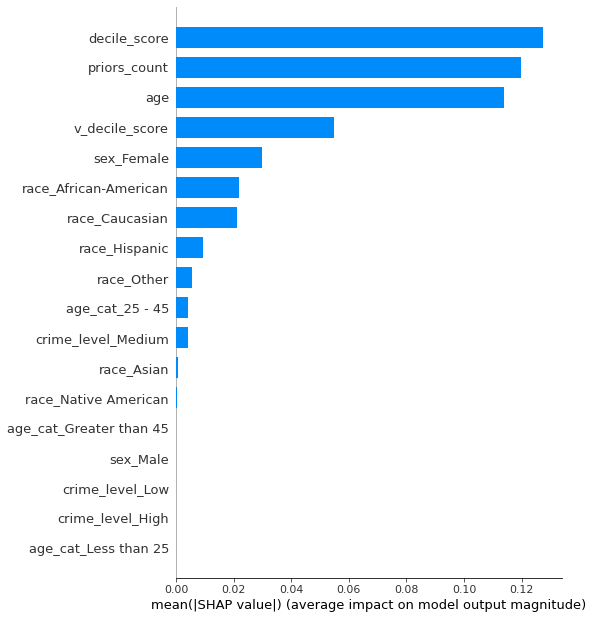

In [36]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(df_c_features)
shap.summary_plot(shap_values, df_c_features, plot_type="bar")

# Observation Based on Shap Value (TreeExplainer):

-From the plot it is analyzed that the whether the individual had been jailed for a new crime in next two years (target value:two_year_recid)is greatly influenced by the decile_score. Here, decile_score indicates general minor crime rate.

-The target variable also highly influenced by priors_count and age of individuals; here, priors_count means number of previous arrests.

-The target variable also notibly influenced by v_decile_score; here, v_decile_score = violate crime rate.

-According to the barchart, female, race(african-American, Caucacian, Hispanic) have a little influence to the target variable. -Others variables have no influence to the target variable

# Using Partial Dependence Plots (PDP):

-It visualizes the effect of one or two features of interest on the prediction results while marginalizing the rest of the other features. More specifically, partial dependence is the expected target response as a function of those one or two features of interest. PDP is a summary-based explainable machine learning method because it includes all instances and summarizes the relationship of the features of interest with the model’s predictions.

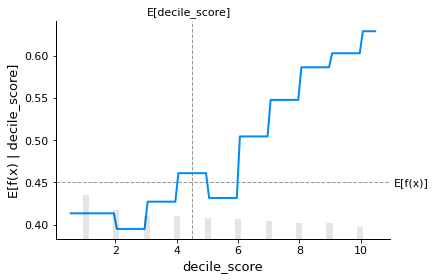

In [37]:
#vertical line-avg value of absence
#Horizental line is avg value of score
#E[f(x)]=expected value of score
shap.plots.partial_dependence(
    'decile_score', model.predict, df_c_features, 
    ice=False, model_expected_value=True, feature_expected_value=True
)

# Observation of the impact of 'decile_score' to the target variable:

-The grey bars on the plot indicate its data distribution. The target variable is gradually increased whith the increased if decile_score. However, two local down are seen in the plot at the decile_score 2-3 and 5-6, that might be because of data deficiency at these points. 

-From the blue line it has been seen that while the number of decile_score iscrease the chances of the individual had been jailed for a new crime in next two years (target variable:two_year_recid) also increases.

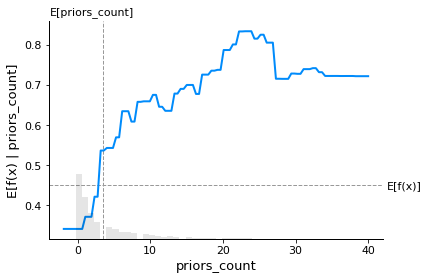

In [38]:
shap.plots.partial_dependence(
    'priors_count', model.predict, df_c_features, 
    ice=False, model_expected_value=True, feature_expected_value=True
)

# Observation of the impact of 'priors_count' to the target variable:

-It is clearly visible that the the target variable is increases with the increase of priors_count; that means,the chances of the individual had been jailed for a new crime in next two years is high while that person's number of previous arrests is also high.

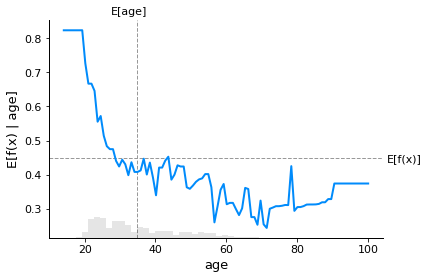

In [39]:
shap.plots.partial_dependence(
    'age', model.predict, df_c_features, 
    ice=False, model_expected_value=True, feature_expected_value=True
)

# Observation of the impact of 'age' to the target variable:

-From the graph it is seen that at the age between 18 to 25 the target variable reaches at high point; after 25 the the target variable score gradually decreased and it reaches at the lowest point at the age 70; a local peak of towards target variable is shown at the age 80, that might be because of small amount of data.

-That means, the chances of the individual had been jailed for a new crime in next two years is high at the age between 18 to 25.

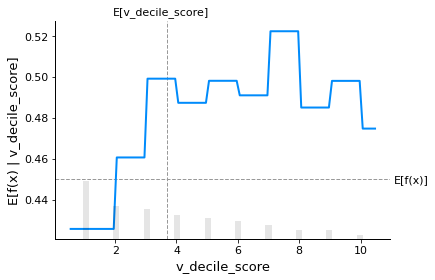

In [40]:
shap.plots.partial_dependence(
    'v_decile_score', model.predict, df_c_features, 
    ice=False, model_expected_value=True, feature_expected_value=True
)

# Observation of the impact of 'v_decile_score' to the target variable:

-The target variable is gradually increased whith the increased if v_decile_score.

-From the blue line it has been seen that while the violent crime score iscreases of a person, the chances of that person have been jailed for a new crime in next two years also increases. At the v_decile_score 7-8 the, chancees of reaching the target variable is showing maximum.

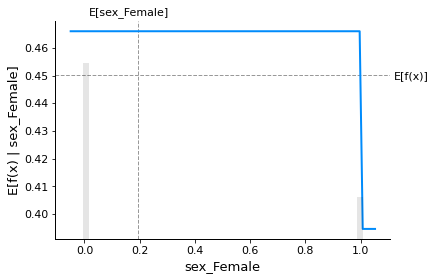

In [41]:
shap.plots.partial_dependence(
    'sex_Female', model.predict, df_c_features, 
    ice=False, model_expected_value=True, feature_expected_value=True
)

# Observation of the impact of 'sex_Female' to the target variable:

-sex_Female is a dummy variable with values of 0 and 1. The grey bars on the plot indicate its data distribution. 

-At the blue line, we can see the expected score is higher when this feature has a value of 1 versus 0. This makes sense female sex have higher chance of back to jail in next two years with a new crime.

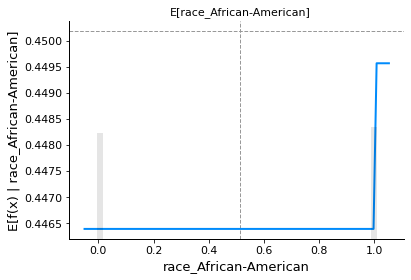

In [42]:
shap.plots.partial_dependence(
    'race_African-American', model.predict, df_c_features, 
    ice=False, model_expected_value=True, feature_expected_value=True
)

# Observation of the impact of 'race_African-American' to the target variable:

-Graphs shows that African-American have higher chance of back to jail in next two years with a new crime compared to other races.

# Using SHapley Additive exPlanations (SHAP):
It is a practical method based on Shapley values. So, on the below SHAP between summary plot, we can see both feature importance and the effects on the predictions. As the number of features increases, the number of possible coalitions increases exponentially, resulting in a computation increase. So we usually approximate the Shapley values, rather than applying the exact calculations. And that’s why here I will apply SHAP. SHAP includes an estimation approach of Shapley values, but more than that. Besides being an instance-based method to explain one instance, SHAP also contains methods of combining the Shapley values of all instances to summarize the model predictions.

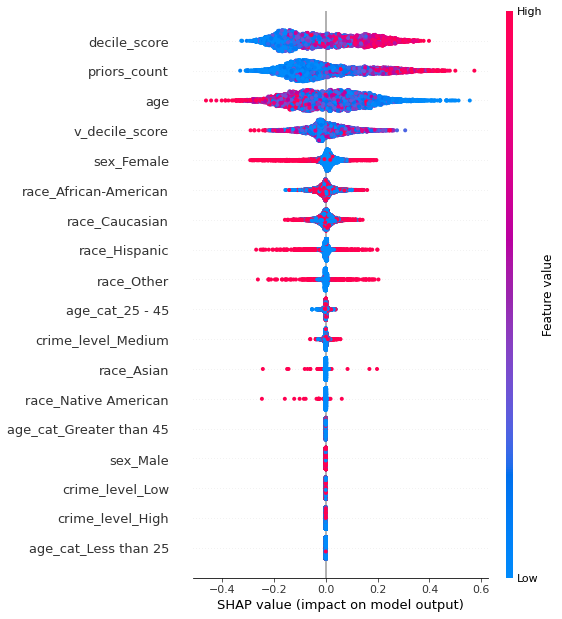

In [43]:
#Let’s use the TreeExplainer function from shap and make a summary plot
#Along the y-axis, the features are sorted from top to down by the sum of SHAP value magnitudes of all instances
#Along the x-axis, for each feature, you can also see the distribution of the impacts each feature has on the model’s predictions
#The color of dots represents the values of the features: red high and blue low
explainer = shap.TreeExplainer(model)
shap_values = explainer(df_c_features)
shap.summary_plot(shap_values, df_c_features)

# Comments about Shap Summary Plot(TreeExplainer):

-We can see that 'decile_score' is the first most important feature for our model. The higher values of decile_score (red dots) tend to contribute positively to the prediction. In comparison, the lower values (blue dots) have negative contributions. This makes sense since the more decile_score a person have, the more likely that person will be in been jail for a new crime in next two years. The same observation is true form the variable 'priors_count'.

-The oposite scenerio is shown in the variable'age'. The higher lower value of age (blue dots) tend to contribute positively to the prediction and vice versa.

-We can see that 'v_decile_score' impact is showing little bit confusing in the plot.

# Using scatter plot:
 I Have used this to focus on one feature’s effect across the entire dataset through scatter plot

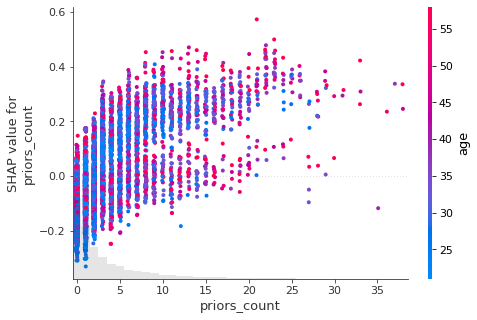

In [44]:
#We can also focus on one feature’s effect across the entire dataset through scatter plot
shap.plots.scatter(shap_values[:,'priors_count'], color=shap_values)

# Comment about scatter plot:

-The grey bars represent the distribution of the feature, while the dots show the SHAP values.

-The vertical dispersion at a single value of 'priors_count' shows interaction effects with other features. Using the color=shap_values argument, the scatter plot picked the best feature to color by to reveal the interactions.

-Here, we can see that the feature 'priors_count' has a no such clear impact on scores (higher SHAPs) with high or low age value.

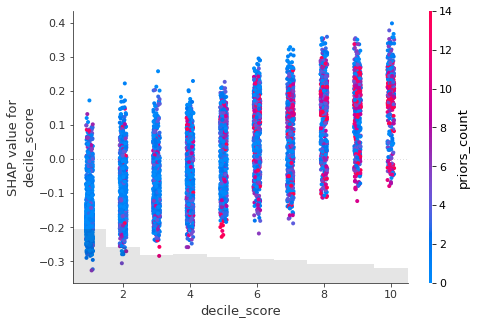

In [45]:
#We can also focus on one feature’s effect across the entire dataset through scatter plot
shap.plots.scatter(shap_values[:,'decile_score'], color=shap_values)

# Comment about scatter plot:

-We can see that the feature 'decile_score' has a moderate impact on scores (higher SHAPs) with higher 'priors_count' values.

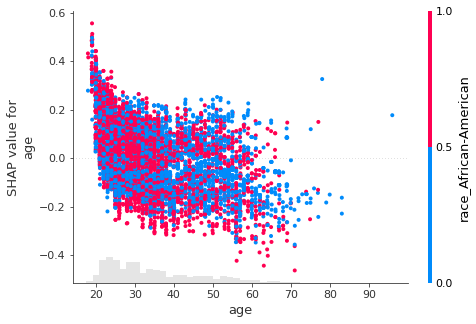

In [46]:
shap.plots.scatter(shap_values[:,'age'], color=shap_values)

# Comment about scatter plot:

-We can see that the feature 'age' has higher impact on target variable(higher SHAPs) with higher race_African-American values. When the age is lower and race_African-American value is higher, the Shap value is also seeing higher. 

# Using Water Fall Chart: 
-A waterfall chart is a form of data visualization that helps in understanding the cumulative effect of sequentially introduced positive or negative values.

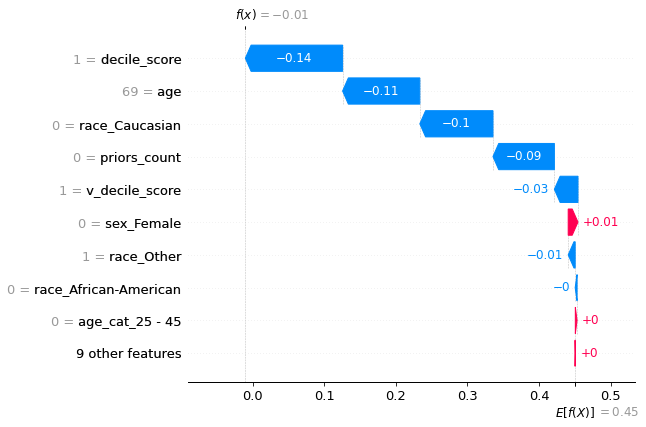

In [47]:
#A waterfall chart is a form of data visualization that helps in understanding the cumulative effect of sequentially introduced 
#positive or negative values.
shap.plots.waterfall(shap_values[0])

# Comment about Waterfall Plot:

On this plot, we are seeing two values. At the bottom of the plot, E(f(x)), the average predicted score of the dataset is 0.45. At the top of the plot, f(x), the predicted score for the sample is, is -01. Between these two values, the waterfall plots how each feature contributes to the changes of prediction from E(f(x)) to f(x). 

Here, the 'decile_score', age, race_caucasian has the most impact. It pulled the prediction down, while the sex_female value has increased the prediction.

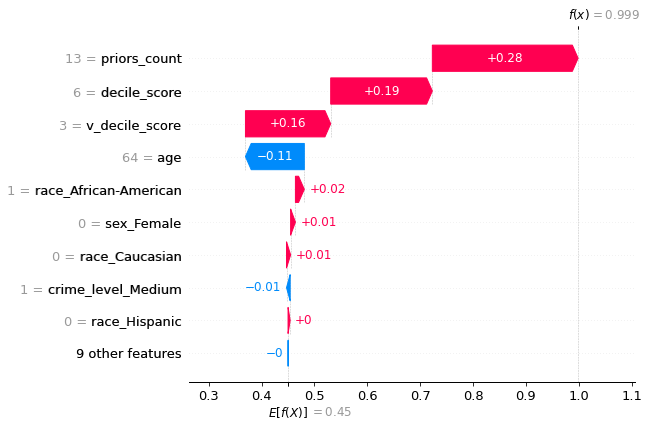

In [48]:
#Another instance’s waterfall plot
shap.plots.waterfall(shap_values[20])

# Comment About Waterfall Plot

-On this plot, we are seeing two values. At the bottom of the plot, E(f(x)), the average predicted score of the dataset is 0.45. At the top of the plot, f(x), the predicted score for the sample is, is .99. Between these two values, the waterfall plots how each feature contributes to the changes of prediction from E(f(x)) to f(x). 

-Here we can see the result is completely changed; the priors_count, decile_score, v_decile_score at the value of 13, 6, 3 consequently have strong positive influence to increase the sample prediction; the age at the value 64 has oposite influence.

# Using Local Interpretable Model-agnostic Explanations (LIME):

-Local Interpretable Model-Agnostic Explanations (LIME) is another popular method to explain one instance. Unlike SHAP, LIME suggests learning interpretable local surrogate models around the prediction to estimate features’ effects.

Suppose you want to explain how a ‘black box’ model makes a specific prediction on one instance. Here are the general steps of LIME:

#perturb the dataset, and get the ‘black box’ model predictions for the new points

#weight the new samples based on their proximity to the instance of interest

#train a weighted, interpretable model on the dataset with the variations, i.e., learn a local surrogate model

#this local surrogate model should approximate the ‘black box’ model’s prediction locally

#the common local surrogate models include linear regression, decision tree

#interpret the local model to explain the prediction

In [49]:
#Here we use the lime_tabular module from lime since our data is tabular
explainer = lime.lime_tabular.LimeTabularExplainer(
    df_c_features.to_numpy(), feature_names=df_c_features.columns, class_names=['two_year_recid'], 
    verbose=True, mode='regression', random_state=33)

In [50]:
#Here we generate explanations for one instance and set the maximum number of features to include in the explanation to be 5.
exp = explainer.explain_instance(df_c_features.iloc[20], model.predict, num_features=5)

Intercept 0.3239313594970047
Prediction_local [0.5604325]
Right: 0.99864966


In [51]:
exp.show_in_notebook(show_table=True)

# Observation about LIME Output: 
The intercept of the linear model created by LIME is presented, followed by the local prediction generated by the linear model, and the actual prediction from our model. We can see that the predicted score for this sample is 0.99864966, whereas the local prediction result is only 0.5604325. The features and their contributions (blue being negative, orange being positive) to this prediction are shown, as well as their feature values for this sample. Here, the feature 'priors_count', 'race_asian', decile_score has positive effects on the prediction at the certain values, while 'age' and 'race_Caucasian' has oposite impact.

In [52]:
#Display of the information of the dataset
df_c_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   age                      7214 non-null   int64
 1   decile_score             7214 non-null   int64
 2   priors_count             7214 non-null   int64
 3   v_decile_score           7214 non-null   int64
 4   sex_Female               7214 non-null   uint8
 5   sex_Male                 7214 non-null   uint8
 6   age_cat_25 - 45          7214 non-null   uint8
 7   age_cat_Greater than 45  7214 non-null   uint8
 8   age_cat_Less than 25     7214 non-null   uint8
 9   race_African-American    7214 non-null   uint8
 10  race_Asian               7214 non-null   uint8
 11  race_Caucasian           7214 non-null   uint8
 12  race_Hispanic            7214 non-null   uint8
 13  race_Native American     7214 non-null   uint8
 14  race_Other               7214 non-null   uint8
 15  crim

# Applying Constraints in the Dataset:
retrain dataset with monotonicity constrain-t is often the case in a modeling problem or project that the functional form of an
acceptable model is constrained in some way. 

The term monotonic relationship is a statistical definition that is used to describe a scenario in which the size of one variable increases as the other variables also increases, or where the size of one variable increases as the other variable also decreases.

In [53]:
#Applying monotonicity constrain
params = {
    'monotone_constraints':'(0,0,1,-1,0,0,-1)'
}
model_constrained = xgb.XGBRegressor(**params, n_estimators=500, max_depth=20, learning_rate=0.1, subsample=0.8, random_state=33)
model_constrained.fit(df_c_features, df_c['two_year_recid'])

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=20, min_child_weight=1, missing=nan,
             monotone_constraints='(0,0,1,-1,0,0,-1)', n_estimators=500,
             n_jobs=8, num_parallel_tree=1, predictor='auto', random_state=33,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

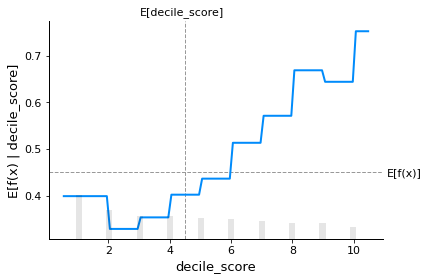

In [54]:
#Display the shap partial dependency plot
import shap
shap.plots.partial_dependence(
    'decile_score', model_constrained.predict, df_c_features, 
    ice=False, model_expected_value=True, feature_expected_value=True
)

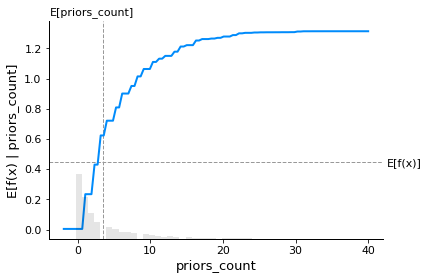

In [55]:
shap.plots.partial_dependence(
    'priors_count', model_constrained.predict, df_c_features, 
    ice=False, model_expected_value=True, feature_expected_value=True
)

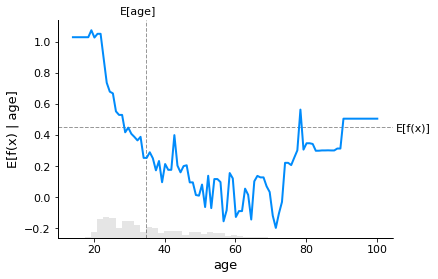

In [56]:
shap.plots.partial_dependence(
    'age', model_constrained.predict, df_c_features, 
    ice=False, model_expected_value=True, feature_expected_value=True
)

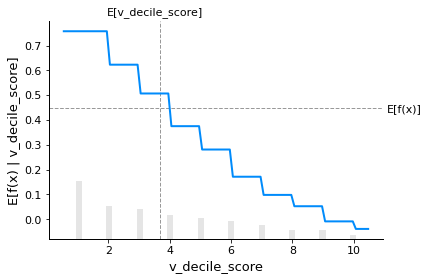

In [57]:
shap.plots.partial_dependence(
    'v_decile_score', model_constrained.predict, df_c_features, 
    ice=False, model_expected_value=True, feature_expected_value=True
)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


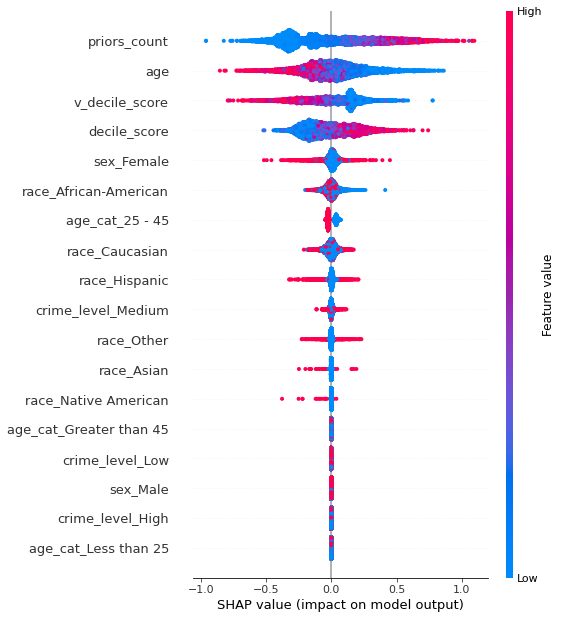

In [58]:
#The updated TreeExplainer plot
explainer = shap.TreeExplainer(model_constrained)
shap_values = explainer(df_c_features)
shap.summary_plot(shap_values, df_c_features)

# Observation About TreeExplainer Plot:

-We can see that 'priors_count' is the first most important feature for our new model. The higher values of priors_count (red dots) tend to contribute positively to the prediction. In comparison, the lower values (blue dots) have negative contributions. This makes sense, since the more priors_count a person have, the more likely that person will be in been jail for a new crime in next two years. The same observation is true form the variable 'decile_score'.

-The oposite scenerio is shown in the variable 'age' and 'v_decile_score'. The higher the value of age and v_decile_score (red dots), these tend to contribute negetively to the prediction and vice versa.


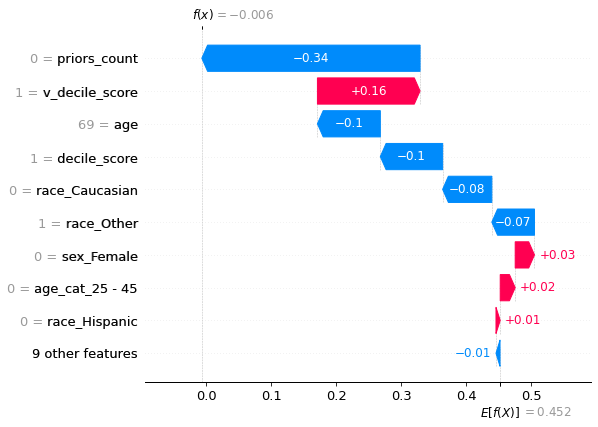

In [59]:
#Creating waterfall plot
shap.plots.waterfall(shap_values[0])

# Comment about Waterfall Plot:
On this plot, we are seeing two values. At the bottom of the plot, E(f(x)), the average predicted score of the dataset is 0.452. At the top of the plot, f(x), the predicted score for the sample is, is -006. Between these two values, the waterfall plots how each feature contributes to the changes of prediction from E(f(x)) to f(x). 
Here, the 'priors_count' has the most impact. It pulled the prediction down, while the 'v_decile_score' value has increased the prediction.

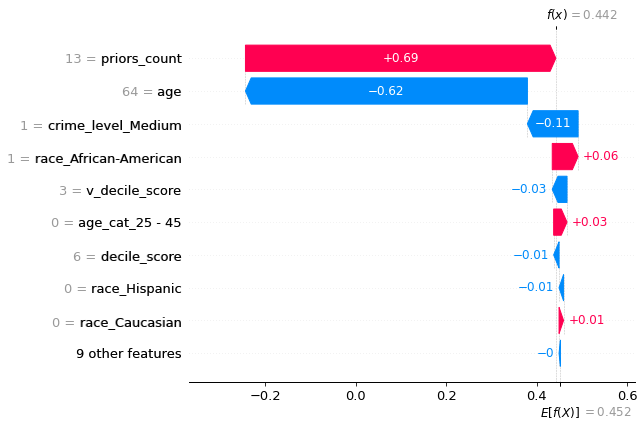

In [60]:
#Updated Waterfall plot
shap.plots.waterfall(shap_values[20])

# Comment about Waterfall Plot:

On this plot, we are seeing two values. At the bottom of the plot, E(f(x)), the average predicted score of the dataset is 0.452. At the top of the plot, f(x), the predicted score for the sample is, is 0.442, which is very near to the average one. Between these two values, the waterfall plots how each feature contributes to the changes of prediction from E(f(x)) to f(x). 
Here, the 'priors_count' has the most impact. It has increased the prediction to happen, while the age value has pulled the prediction.

# Using Lime to the re-shaffle the Dataset

In [61]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    df_c_features.to_numpy(), feature_names=df_c_features.columns, class_names=['two_year_recid'], 
    verbose=True, mode='regression', random_state=33)

In [62]:
exp = explainer.explain_instance(df_c_features.iloc[20], model_constrained.predict, num_features=5)

Intercept 0.24731035190611944
Prediction_local [1.00690098]
Right: 0.44194847


In [63]:
exp.show_in_notebook(show_table=True)

# Observation about LIME Output: 

-We can see that the predicted score for this sample is 0.44194847. The local prediction result is increased here and become 1. Which indicates improvement of the model output.

-The features and their contributions (blue being negative, orange being positive) to this prediction are shown, as well as their feature values for this sample. Here, the feature 'priors_count' with a value of 13, 'decile_score' with a value of 6, v_decile score with a value of 3 have the strongest positive effects on the prediction. The percentage of each features chance to prediction is increased compared to previous one; the negative is shown in the age variable at age 64.
